Assignment-03(mandatory) sunitachoudhary103@gmail.com

Objective -Amazon food reviews polarity prediction based on the given review data by applying K Nearest Neighbors (KNN) algorithm. To build generalized prediction model first step should be necessary cleaning of data as a part of data preprocessing.

    First clean the data ,remove duplicate entries. other Text-pre processing like.. a.Removing Stop-words b.Remove any punctuations or limited set of special characters like , or . or # etc. c.Snowball Stemming the word d.Convert the word to lowercase

        Once we the data is cleaned to be processed we'll use below Feature generation techniques to convert text to numeric vector.

        First sort the data by Time *split the top 10,0000 data into three parts-train,cv,test

    1.Bag Of Words (BoW)- *Apply K-NN with BoW

    ----1.1 Brute force algorithm with BoW

     * Classification report
     * Confusion-matrix

    ----1.2 Kd-tree algorithm with BoW

     * Classification report
     * Confusion-matrix

2.Term Frequency - inverse document frequency (tf-idf)

    Apply K-NN with tf-idf

    ----2.1 Brute force algorithm with tf-idf

    * Classification report
    * Confusion-matrix

    ----2.2 Kd-tree algorithm with tf-idf

    * Classification report
    * Confusion-matrix

3.Word2Vec- 3.1*Avg-W2v

*Apply K-NN with Average-w2v

----3.11 Brute force algorithm with Avg-W2v 
     * Classification report
     * Confusion-matrix

----3.12 Kd-tree algorithm with Avg-W2v
     * Classification report
     * Confusion-matrix

3.2*tf-idf weighted Word2Vec

*Apply K-NN with tf-idf w2v

 ---3.21 Brute force algorithm with Avg-W2v 
     * Classification report
     * Confusion-matrix

----3.22 Kd-tree algorithm with Avg-W2v
     * Classification report
     * Confusion-matrix
     
     
     Prettytable-


In [1]:
!pip install tqdm


distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install PrettyTable

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3

import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
import os

data=sqlite3.connect("database.sqlite")

/home/sunitachoudhary103/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
import pandas as pd
filtered_data=pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score !=3
""",data)
def partition(x):
    if x<3:
        return 'negative'
    return 'positive'
a_score=filtered_data["Score"]
positiveNegative=a_score.map(partition)
filtered_data["Score"]=positiveNegative

In [5]:
print(filtered_data.shape)


(525814, 10)


In [6]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...



1.Data cleaning-Deduplication....means removing duplicate rows, It is necessary to remove duplicates in order to get unbaised results. Checking duplicates based on UserId, ProfileName, Time, Text. If all these values are equal then we will remove those records. (No user can type a review on same exact time for different products


In [7]:
sorted_data=filtered_data.sort_values('ProductId',ascending=True,inplace=False,kind='quickSort',na_position='last')
#de duplication of entries
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

In [8]:
final=final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
print(final.shape)
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#2.Text Preprocessing- 1.Begin by removing the html tags 2.Remove any punctuations or limited set of special characters like , or . or # etc. 3.Check if the word is made up of english letters and is not alpha-numeric 4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters) 5.Convert the word to lowercase 6.Remove Stopwords 7.Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming) After which we collect the words used to describe positive and negative reviews


In [9]:
%%time
import re
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stop=set(stopwords.words('english'))
print(stop)
sno=nltk.stem.SnowballStemmer('english')
print(sno.stem('tasty'))

def cleanhtml(sentence):#function to clean the word of any html-tags
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,'',sentence)
    return cleantext
def cleanpunc(sentence):#function to clean the word of any punctuation or special characters
    cleaned=re.sub(r'[!|?|<|,|/|.]',r'',sentence)
    cleaned=re.sub(r'[;|"|\|)]',r'',cleaned)
    return cleaned


{'own', 'll', "wasn't", 'don', 'most', 'through', 'couldn', 'when', 'am', 'only', 'any', 'were', 'as', 'had', 'will', 'into', 'its', 'on', "mustn't", 'during', "couldn't", 'at', "you'll", 'your', 'her', 'while', 'y', "isn't", 'didn', 'how', 'been', 'this', "hadn't", 'those', 'below', 'my', 'mightn', 'we', "doesn't", 'do', 'd', 'until', 'which', 'or', 'too', 'against', 'have', 'has', 'that', 're', 'why', 'haven', 'mustn', "should've", 'if', "needn't", 'very', 'over', 've', 'myself', "didn't", 'wouldn', 'having', 'ours', 'is', 'more', 'are', "hasn't", 'does', 'to', 'hers', 'needn', 'themselves', 'no', 'aren', 'up', 'further', 'was', 'under', "weren't", 'an', 'ain', 'yours', 's', 'above', "aren't", 'itself', 'and', 'now', "you've", 'what', 'then', "it's", 'shouldn', 'he', 'their', "don't", 'you', 'about', 'by', 'me', 'between', 'doing', 'before', 'other', "you're", 'so', 'once', 'for', 'out', 'such', 'few', 'whom', 'with', "shouldn't", 'because', 'who', 'herself', 'shan', 'in', 'our', 'hi

In [10]:
%%time

#Code for implementing step-by-step the checks mentioned in the pre-processing phase
j=0
str1=''
sn=''
final_string=[]
positive_R=[]
negative_R=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent)
    sent=cleanhtml(sent)#remove html tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha())& (len(cleaned_words)>2):
                if(cleaned_words.lower() not in stop):
                    sn=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(sn)
                    if(final['Score'].values)[j]=='positive':
                        positive_R.append(sn)
                    if(final['Score'].values)[j]=='negative':
                        negative_R.append(sn)
                        
                else:
                    continue
            else:
                continue
       #print(filtered_sentance)
    str1=b" ".join(filtered_sentence) #final string of clean_words
    #print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
    final_string.append(str1)
    j+=1


CPU times: user 6min, sys: 763 ms, total: 6min
Wall time: 6min


In [11]:
%%time

final['cleaned_Text']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review
final['cleaned_Text']=final['cleaned_Text'].str.decode('utf-8')
print(final.head(3))


print(final.columns)

            Id   ProductId          UserId            ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL        shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                  Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4  sally sue "sally sue"   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  positive   939340800   
138688                     1                       1  positive  1194739200   
138689                     1                       1  positive  1191456000   

                                           Summary  \
138706                   EVERY book is educational   
138688  Love the book, miss the hard cover version   
138689               chicken soup with rice months   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138688  I grew up reading these Sendak books, and watc...   
138689  Th

3.Techniques for Encoding

1.BAG OF WORDS-In BoW we construct a dictionary that contains set of all unique words from our text review dataset.The frequency of the word is counted here. if there are d unique words in our dictionary then for every sentence or review the vector will be of length d and count of word from review is stored at its particular location in vector. The vector will be highly sparse in such case.


In [12]:
%%time
from datetime import timedelta
#sorting based on time
#final['Time']=pd.to_datetime(final['Time'])
final['Time']=pd.to_datetime(final.Time)

final=final.sort_values('Time',ascending=True,inplace=False,kind='quickSort',na_position='last')


CPU times: user 2.48 s, sys: 188 ms, total: 2.66 s
Wall time: 958 ms


In [13]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...


** Spliting the top 10,0000 data into three parts-train,cv,test


In [14]:
X_train, y_train = final['cleaned_Text'].iloc[0:60000], final['Score'].iloc[0:60000]
X_cv, y_cv = final['cleaned_Text'].iloc[60000:80000], final['Score'].iloc[60000:80000]
X_test, y_test = final['cleaned_Text'].iloc[80000:100000], final['Score'].iloc[80000:100000]


In [15]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape

((60000,), (60000,), (20000,), (20000,), (20000,), (20000,))

1.BoW-

In [15]:
#BoW
count_vect = CountVectorizer(ngram_range=(1, 1))
count_vect.fit(X_train)
X_train=count_vect.transform(X_train)
X_cv=count_vect.transform(X_cv)
X_test=count_vect.transform(X_test)
print(X_cv.shape,X_train.shape)


(20000, 55097) (60000, 55097)



 1.1 Brute force-BOW

In [17]:
%%time
#brute force algorithm for BoW
from sklearn.metrics import f1_score
f_score=[]
for i in range(1,13,2):
    #instantiate learning model (k=13)
    knn=KNeighborsClassifier(n_neighbors=i,algorithm ='brute')
    knn.fit(X_train,y_train)#fitting the model on train
    pred=knn.predict(X_cv)#predict the response on the cv 
    #evaluate cv accuracy
    #label=labels['positive','negative']
    #class_label=['negative','positive']
    f=f1_score(y_cv,pred,average='micro')
    
    #acc=accuracy_score(y_cv,pred,normalize=True)*float(100)
    f_score.append(f)
    #print('\n cv accuracy for k=%d is %d%%' %(i,acc))
    print('\n cv f_score for k=%d is %0.3f' %(i,f))


 cv f_score for k=1 is 0.811

 cv f_score for k=3 is 0.857

 cv f_score for k=5 is 0.864

 cv f_score for k=7 is 0.865

 cv f_score for k=9 is 0.865

 cv f_score for k=11 is 0.865
CPU times: user 5min 3s, sys: 1min 54s, total: 6min 57s
Wall time: 6min 24s


In [18]:
print(f_score)

[0.8113, 0.8571000000000001, 0.86385, 0.8654500000000002, 0.86525, 0.8653]


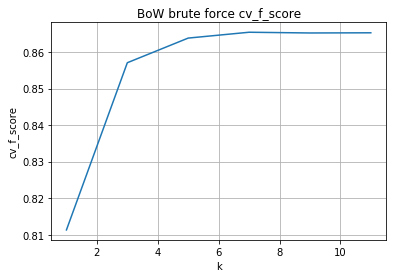

In [19]:
import matplotlib.pyplot as plt
k=[i for i in range(1,13,2)]

plt.plot(k,f_score)
plt.xlabel("k")
plt.ylabel("cv_f_score")
plt.title("BoW brute force cv_f_score")
plt.grid()
plt.show()

In [20]:
knn=KNeighborsClassifier(7)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
f=f1_score(y_test,pred,average='micro')
#acc=accuracy_score(y_test,pred,normalize=True)*float(100)
print('\n ****Test f_score for k=7 is %0.3f' %(f))


 ****Test f_score for k=7 is 0.869


* Test accuracy-

In [21]:
test_accuracy = accuracy_score(y_test, pred)
test_error = 1 - test_accuracy
print("test_error:",test_error)
print("test_accuracy",test_accuracy)

test_error: 0.13115
test_accuracy 0.86885


In [22]:
#for brute force-BoW
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.62      0.05      0.10      2678
   positive       0.87      0.99      0.93     17322

avg / total       0.84      0.87      0.82     20000



In [23]:
#confusion matrix for brute force-BoW
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  143,  2535],
       [   88, 17234]])

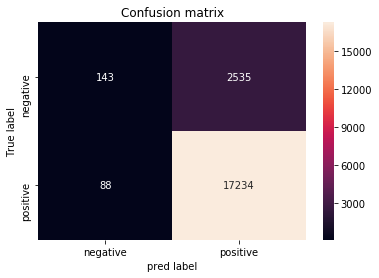

In [24]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm = pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

1.2 Kd-tree for BoW-

In [17]:
%%time
#kd tree for Bow
from sklearn.metrics import f1_score
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=300)
X_train = svd.fit_transform(X_train)
X_test = svd.fit_transform(X_test)
X_cv = svd.fit_transform(X_cv)

f_score=[]
for i in range(1,13,2):
    #instantiate learning model (k=13)
    knn=KNeighborsClassifier(n_neighbors=i,algorithm ='kd_tree')
    knn.fit(X_train,y_train)#fitting the model on train
    pred=knn.predict(X_cv)#predict the response on the cv 
    #evaluate cv accuracy
    f=f1_score(y_cv,pred,average='micro')
    f_score.append(f)
    #acc=accuracy_score(y_cv,pred,normalize=True)*float(100)
    print('\n cv_f_score for k=%d is %.03f' %(i,f))


 cv_f_score for k=1 is 0.734

 cv_f_score for k=3 is 0.801

 cv_f_score for k=5 is 0.830

 cv_f_score for k=7 is 0.845

 cv_f_score for k=9 is 0.852

 cv_f_score for k=11 is 0.856
CPU times: user 1h 44min 58s, sys: 15.9 s, total: 1h 45min 14s
Wall time: 1h 43min 39s


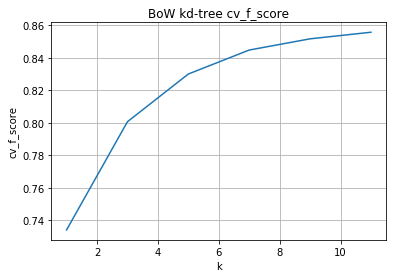

In [19]:
import matplotlib.pyplot as plt
k=[i for i in range(1,13,2)]

plt.plot(k,f_score)
plt.xlabel("k")
plt.ylabel("cv_f_score")
plt.title("BoW kd-tree cv_f_score")
plt.grid()
plt.show()

In [20]:
#test f_score
knn=KNeighborsClassifier(11)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
f=f1_score(y_test,pred,average='micro')
print('\n ****Test f_score for k=11 is %.03f' %(f))


 ****Test f_score for k=11 is 0.857


In [21]:
test_accuracy = accuracy_score(y_test, pred)
test_error = 1 - test_accuracy
print("test_error:",test_error)
print("test_accuracy",test_accuracy)

test_error: 0.14339999999999997
test_accuracy 0.8566


In [22]:
#for kd-tree-BoW
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.12      0.01      0.02      2678
   positive       0.87      0.99      0.92     17322

avg / total       0.77      0.86      0.80     20000



In [23]:
#confusion matrix for brute force-BoW
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[   31,  2647],
       [  221, 17101]])

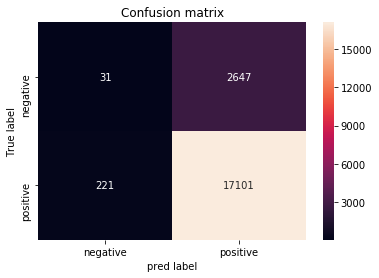

In [24]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

2.TFIDF -

In [32]:
X_train, y_train = final['cleaned_Text'].iloc[0:60000], final['Score'].iloc[0:60000]
X_cv, y_cv = final['cleaned_Text'].iloc[60000:80000], final['Score'].iloc[60000:80000]
X_test, y_test = final['cleaned_Text'].iloc[80000:100000], final['Score'].iloc[80000:100000]

# Initializing tfidf vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))

# Fitting for tfidf vectorization
tfidf_vect.fit(X_train)
X_train= tfidf_vect.transform(X_train)
X_test = tfidf_vect.transform(X_test)
X_cv = tfidf_vect.transform(X_cv)
X_train.shape,y_train.shape

((60000, 55097), (60000,))

2.1 Brute force algorithm for TFIDF-

In [33]:
#brute force algorithm for TFIDF 
f_score=[]
for i in range(1,13,2):
    #instantiate learning model (k=13)
    knn=KNeighborsClassifier(n_neighbors=i,algorithm ='brute')
    knn.fit(X_train,y_train)#fitting the model on train
    pred=knn.predict(X_cv)#predict the response on the cv 
    #evaluate cv accuracy
    f=f1_score(y_cv,pred,average='micro')
    f_score.append(f)
    #acc=accuracy_score(y_cv,pred,normalize=True)*float(100)
    print('\n cv_f_score for k=%d is %.03f' %(i,f))
    
   


 cv_f_score for k=1 is 0.836

 cv_f_score for k=3 is 0.866

 cv_f_score for k=5 is 0.872

 cv_f_score for k=7 is 0.873

 cv_f_score for k=9 is 0.874

 cv_f_score for k=11 is 0.873


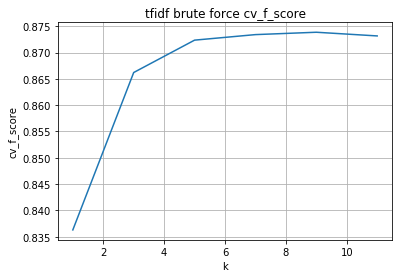

In [34]:
import matplotlib.pyplot as plt
k=[i for i in range(1,13,2)]

plt.plot(k,f_score)
plt.xlabel("k")
plt.ylabel("cv_f_score")
plt.title("tfidf brute force cv_f_score")
plt.grid()
plt.show()

In [35]:
knn=KNeighborsClassifier(9)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
f=f1_score(y_test,pred,average='micro')
print('\n ****Test f_score for k=9 is %.03f' %(f))


 ****Test f_score for k=9 is 0.873


In [36]:
test_accuracy = accuracy_score(y_test, pred)
test_error = 1 - test_accuracy
print("test_error:",test_error)
print("test_accuracy",test_accuracy)

test_error: 0.12665000000000004
test_accuracy 0.87335


Classification report-

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.70      0.10      0.17      2678
   positive       0.88      0.99      0.93     17322

avg / total       0.85      0.87      0.83     20000



confusion matrix-

In [38]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[  255,  2423],
       [  110, 17212]])

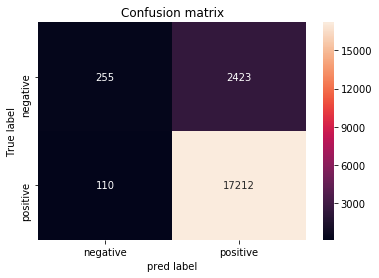

In [39]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

2.2 kd-tree for tfidf-

In [40]:
#Kd tree for TFIDF


from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=300)
X_train = svd.fit_transform(X_train)
X_test = svd.fit_transform(X_test)
X_cv = svd.fit_transform(X_cv)
f_score=[]
for i in range(1,10,2):
    #instantiate learning model (k=10)
    knn=KNeighborsClassifier(n_neighbors=i,algorithm ='kd_tree')
    knn.fit(X_train,y_train)#fitting the model on train
    pred=knn.predict(X_cv)#predict the response on the cv 
    #evaluate cv accuracy
    f=f1_score(y_cv,pred,average='micro')
    f_score.append(f)
    print('\n cv f_score for k=%d is %0.3f' %(i,f))



 cv f_score for k=1 is 0.786

 cv f_score for k=3 is 0.831

 cv f_score for k=5 is 0.844

 cv f_score for k=7 is 0.851

 cv f_score for k=9 is 0.854


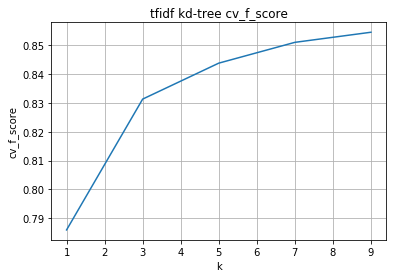

In [41]:
import matplotlib.pyplot as plt
k=[i for i in range(1,10,2)]

plt.plot(k,f_score)
plt.xlabel("k")
plt.ylabel("cv_f_score")
plt.title("tfidf kd-tree cv_f_score")
plt.grid()
plt.show()

In [42]:
knn=KNeighborsClassifier(9)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
f=f1_score(y_test,pred,average='micro')
print('\n ****Test f_score for k=9 is %.03f' %(f))


 ****Test f_score for k=9 is 0.862


In [43]:
test_accuracy = accuracy_score(y_test, pred)
test_error = 1 - test_accuracy
print("test_error:",test_error)
print("test_accuracy",test_accuracy)

test_error: 0.13815
test_accuracy 0.86185


Classification report-

In [44]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.38      0.05      0.09      2678
   positive       0.87      0.99      0.93     17322

avg / total       0.80      0.86      0.81     20000



Confusion matrix-

In [45]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[  132,  2546],
       [  217, 17105]])

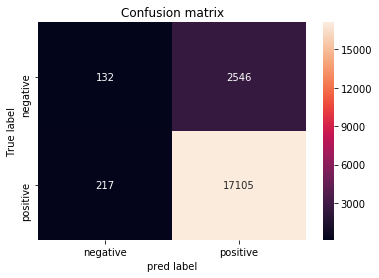

In [46]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

3.Word2vec-

In [16]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [17]:
#Train your own Word2Vec model using your own train text corpus
#spliting the data
X_train, y_train = final['cleaned_Text'].iloc[0:60000],final['Score'].iloc[0:60000]
X_cv, y_cv = final['cleaned_Text'].iloc[60000:80000],final['Score'].iloc[60000:80000]
X_test, y_test = final['cleaned_Text'].iloc[80000:100000],final['Score'].iloc[80000:100000]
print(X_train.shape,y_train.shape,X_cv.shape,y_cv.shape,X_test.shape,y_test.shape)
    

(60000,) (60000,) (20000,) (20000,) (20000,) (20000,)


In [18]:
import gensim
from gensim import utils
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from gensim import parsing, corpora, matutils, interfaces, models, similarities, summarization, utils


train_sent=[]

for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    train_sent.append(filtered_sentence)
print(len(train_sent))

60000


In [19]:
cv_sent=[]

for sent in X_cv:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    cv_sent.append(filtered_sentence)
print(len(cv_sent))

20000


In [20]:
test_sent=[]

for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    test_sent.append(filtered_sentence)
print(len(test_sent))

20000


In [21]:
train_w2v_model = gensim.models.Word2Vec(train_sent,min_count=5,size=50,workers=4)
train_words = list(train_w2v_model.wv.vocab)
print(len(train_words))

10239


3.1Avg W2V-

In [35]:
#avg w2v
#Avg-w2v for train data

train_vectors = []
for sent in tqdm(train_sent):
    train_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec=train_w2v_model.wv[word]
            train_vec+=vec
            cnt_words+=1
        except:
            pass
    train_vec/=cnt_words
    train_vectors.append(train_vec)
print(len(train_vectors))
print(len(train_vectors[0]))


100%|██████████| 60000/60000 [00:07<00:00, 7986.97it/s]

60000
50


In [36]:
%%time
#Avg-w2v for cv data
cv_vectors = []
for sent in tqdm(cv_sent):
    cv_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec=train_w2v_model.wv[word]
            cv_vec+=vec
            cnt_words+=1
        except:
            pass
    cv_vec/=cnt_words
    cv_vectors.append(cv_vec)
print(len(cv_vectors))
print(len(cv_vectors[0]))


100%|██████████| 20000/20000 [00:02<00:00, 7562.36it/s]

20000
50
CPU times: user 2.65 s, sys: 28.1 ms, total: 2.67 s
Wall time: 2.66 s


In [37]:
%%time
#Avg-w2v for test data
test_vectors = []
for sent in tqdm(test_sent):
    test_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec=train_w2v_model.wv[word]
            test_vec+=vec
            cnt_words+=1
        except:
            pass
    test_vec/=cnt_words
    test_vectors.append(test_vec)
print(len(test_vectors))
print(len(test_vectors[0]))


100%|██████████| 20000/20000 [00:02<00:00, 7677.42it/s]

20000
50
CPU times: user 2.63 s, sys: 4.11 ms, total: 2.64 s
Wall time: 2.62 s


In [38]:
X_train = train_vectors
X_cv = cv_vectors
X_test = test_vectors
print(len(X_train),len(X_test),len(X_cv))

60000 20000 20000


3.11 Brute force-avg w2v

In [57]:
%%time
# brute force algorithm for avg-w2v
f_score=[]
for i in range(1,15,2):
    #instantiate learning model (k=30)
    knn=KNeighborsClassifier(n_neighbors=i,algorithm ='brute')
    knn.fit(X_train,y_train)#fitting the model on train
    pred=knn.predict(X_cv)#predict the response on the cv 
    #evaluate cv accuracy
    
    f=f1_score(y_cv,pred,average='micro')
    f_score.append(f)
    print('\n cv_f_score for k=%d is %.03f' %(i,f))
   




 cv_f_score for k=1 is 0.845

 cv_f_score for k=3 is 0.872

 cv_f_score for k=5 is 0.878

 cv_f_score for k=7 is 0.880

 cv_f_score for k=9 is 0.881

 cv_f_score for k=11 is 0.880

 cv_f_score for k=13 is 0.880
CPU times: user 3min 2s, sys: 1min 12s, total: 4min 14s
Wall time: 3min 39s


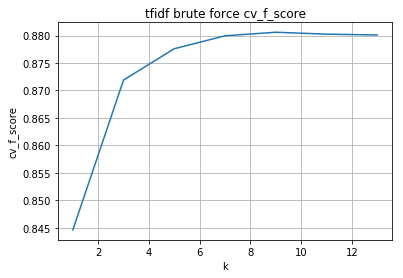

In [58]:

import matplotlib.pyplot as plt
k=[i for i in range(1,15,2)]

plt.plot(k,f_score)
plt.xlabel("k")
plt.ylabel("cv_f_score")
plt.title("tfidf brute force cv_f_score")
plt.grid()
plt.show()

In [59]:
%%time
# brute force algorithm for avg-w2v-test accuracy
knn=KNeighborsClassifier(11)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
f=f1_score(y_test,pred,average='micro')
print('\n ****Test f_score for k=11 is %.03f' %(f))



 ****Test f_score for k=11 is 0.880
CPU times: user 2min 58s, sys: 0 ns, total: 2min 58s
Wall time: 2min 58s


In [60]:
test_accuracy = accuracy_score(y_test, pred)
test_error = 1 - test_accuracy
print("test_error:",test_error)
print("test_accuracy",test_accuracy)

test_error: 0.11975000000000002
test_accuracy 0.88025


In [61]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.68      0.20      0.31      2678
   positive       0.89      0.99      0.93     17322

avg / total       0.86      0.88      0.85     20000



In [62]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[  527,  2151],
       [  244, 17078]])

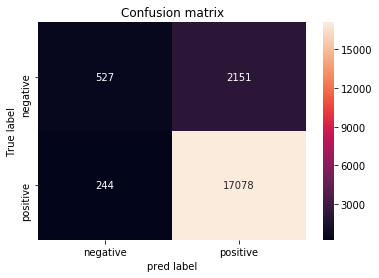

In [63]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

3.12- Kd tree for avg w2v-

In [40]:

# kd-tree algorithm for avg-w2v
from sklearn.metrics import f1_score
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=300)
X_train = svd.fit_transform(X_train)
X_test = svd.fit_transform(X_test)
X_cv = svd.fit_transform(X_cv)
f_score=[]
for i in range(1,13,2):
    #instantiate learning model (k=13)
    knn=KNeighborsClassifier(n_neighbors=i,algorithm ='kd_tree')
    knn.fit(X_train,y_train)#fitting the model on train
    pred=knn.predict(X_cv)#predict the response on the cv 
    #evaluate cv accuracy
    f=f1_score(y_cv,pred,average='micro')
    f_score.append(f)
    print('\n cv_f_score for k=%d is %.03f' %(i,f))
   
    


 cv_f_score for k=1 is 0.833

 cv_f_score for k=3 is 0.861

 cv_f_score for k=5 is 0.868

 cv_f_score for k=7 is 0.870

 cv_f_score for k=9 is 0.870

 cv_f_score for k=11 is 0.871


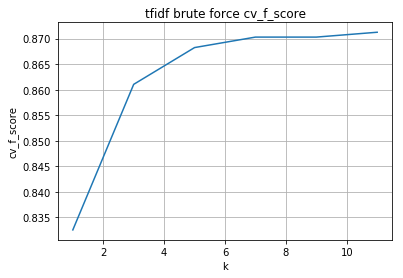

In [41]:
import matplotlib.pyplot as plt
k=[i for i in range(1,13,2)]

plt.plot(k,f_score)
plt.xlabel("k")
plt.ylabel("cv_f_score")
plt.title("tfidf brute force cv_f_score")
plt.grid()
plt.show()

In [42]:
knn=KNeighborsClassifier(11)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
f=f1_score(y_test,pred,average='micro')
print('\n ****Test f_score for k=11 is %.03f' %(f))




 ****Test f_score for k=11 is 0.853


In [43]:
test_accuracy = accuracy_score(y_test, pred)
test_error = 1 - test_accuracy
print("test_error:",test_error)
print("test_accuracy",test_accuracy)


test_error: 0.14654999999999996
test_accuracy 0.85345


In [44]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.09      0.01      0.02      2678
   positive       0.87      0.98      0.92     17322

avg / total       0.76      0.85      0.80     20000



In [45]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[   28,  2650],
       [  281, 17041]])

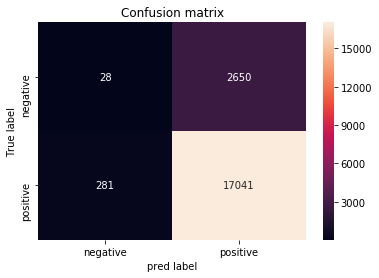

In [46]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

3.22-TFIDF_w2v 

In [71]:
#TFIDF-W2V


X_train, y_train = final['cleaned_Text'].iloc[0:60000], final['Score'].iloc[0:60000]
X_cv, y_cv = final['cleaned_Text'].iloc[60000:80000], final['Score'].iloc[60000:80000]
X_test, y_test = final['cleaned_Text'].iloc[80000:100000], final['Score'].iloc[80000:100000]

# Initializing tfidf vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 1))

# Fitting for tfidf vectorization
tfidf_vect.fit(X_train)
X_train = tfidf_vect.transform(X_train)
X_test = tfidf_vect.transform(X_test)
X_cv = tfidf_vect.transform(X_cv)
#we are converting dictionary with word as key and idf as value
dictionary = dict(zip(tfidf_vect.get_feature_names(),list(tfidf_vect.idf_)))
print(X_train.shape,y_train.shape)


#tfidf_feat=tfidf_vect.get_feature_names()# tfidf word/col names

(60000, 55097) (60000,)


In [72]:
%%time
tfidf_feat = tfidf_vect.get_feature_names()
tfidf_train_vectors = []
row = 0
for sent in tqdm(train_sent):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = train_w2v_model.wv[word]
            #tf_idf = X_train[row, tfidf_feat.index(word)](prev.............)
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
    

100%|██████████| 60000/60000 [00:17<00:00, 3335.19it/s]

CPU times: user 18.5 s, sys: 2.77 s, total: 21.3 s
Wall time: 18 s


In [73]:
len(tfidf_train_vectors)

60000

In [74]:
%%time
#tfidf w2v for cv data
tfidf_feat = tfidf_vect.get_feature_names()
tfidf_cv_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in cv_sent: # for each review/sentence
    cv_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = train_w2v_model.wv[word]
            # obtain the tf_idf of a word in a sentence/review
            #tf_idf = X_cv[row, tfidf_feat.index(word)]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            cv_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    cv_vec /= weight_sum
    tfidf_cv_vectors.append(cv_vec)
    row += 1
len(tfidf_cv_vectors)

CPU times: user 5.6 s, sys: 37.7 ms, total: 5.64 s
Wall time: 5.6 s


In [75]:
#tfidf w2v for test data

tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in test_sent: # for each review/sentence
    test_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = train_w2v_model.wv[word]
            # obtain the tf_idf of a word in a sentence/review
            #tf_idf = X_test[row, tfidf_feat.index(word)]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            test_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    test_vec /= weight_sum
    tfidf_test_vectors.append(test_vec)
    row += 1
len(tfidf_test_vectors)

20000

In [76]:
X_train = tfidf_train_vectors
X_cv = tfidf_cv_vectors
X_test = tfidf_test_vectors 
len(X_train)
print(len(X_cv))
print(len(y_cv))

20000
20000


3.21-Brute force-tfidf-w2v

In [77]:
#brute force algorithm for tfidf-w2v
f_score=[]
for i in range(1,15,2):
    
    #instantiate learning model (k=15)
    knn=KNeighborsClassifier(n_neighbors=i,algorithm ='brute')
    knn.fit(X_train,y_train)#fitting the model on train
    pred=knn.predict(X_cv)#predict the response on the cv 
    #evaluate cv accuracy
    f=f1_score(y_cv,pred,average='micro')
    f_score.append(f)
    print('\n cv_f_score for k=%d is %.03f' %(i,f))
   
    



 cv_f_score for k=1 is 0.831

 cv_f_score for k=3 is 0.863

 cv_f_score for k=5 is 0.869

 cv_f_score for k=7 is 0.873

 cv_f_score for k=9 is 0.874

 cv_f_score for k=11 is 0.874

 cv_f_score for k=13 is 0.874


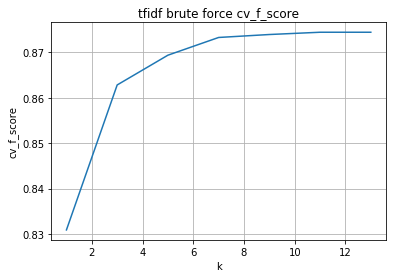

In [78]:
import matplotlib.pyplot as plt
k=[i for i in range(1,15,2)]

plt.plot(k,f_score)
plt.xlabel("k")
plt.ylabel("cv_f_score")
plt.title("tfidf brute force cv_f_score")
plt.grid()
plt.show()

In [79]:
knn=KNeighborsClassifier(11)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
f=f1_score(y_test,pred,average='micro')
print('\n ****Test f_score for k=11 is %.03f' %(f))




 ****Test f_score for k=11 is 0.876


In [80]:
test_accuracy = accuracy_score(y_test, pred)
test_error = 1 - test_accuracy
print("test_error:",test_error)
print("test_accuracy",test_accuracy)

test_error: 0.12429999999999997
test_accuracy 0.8757


In [81]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.64      0.17      0.26      2678
   positive       0.88      0.99      0.93     17322

avg / total       0.85      0.88      0.84     20000



In [82]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[  448,  2230],
       [  256, 17066]])

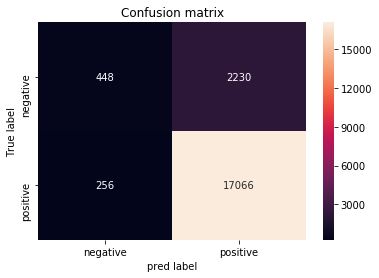

In [83]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

3.22-kd tree tfidf-w2v

In [84]:
#kd tree for tfidf-w2v
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=300)
X_train = svd.fit_transform(X_train)
X_test = svd.fit_transform(X_test)
X_cv = svd.fit_transform(X_cv)
f_score=[]
for i in range(1,15,2):
    #instantiate learning model (k=15)
    knn=KNeighborsClassifier(n_neighbors=i,algorithm ='kd_tree')
    knn.fit(X_train,y_train)#fitting the model on train
    pred=knn.predict(X_cv)#predict the response on the cv 
    #evaluate cv accuracy
    f=f1_score(y_cv,pred,average='micro')
    f_score.append(f)
   
    print('\n cv accuracy for k=%d is %0.3f' %(i,f))


 cv accuracy for k=1 is 0.799

 cv accuracy for k=3 is 0.840

 cv accuracy for k=5 is 0.853

 cv accuracy for k=7 is 0.857

 cv accuracy for k=9 is 0.860

 cv accuracy for k=11 is 0.860

 cv accuracy for k=13 is 0.861


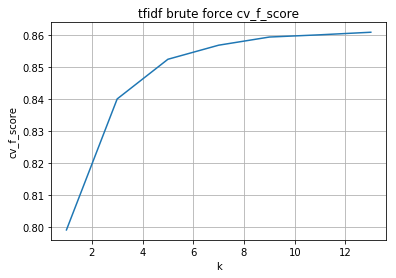

In [85]:
import matplotlib.pyplot as plt
k=[i for i in range(1,15,2)]

plt.plot(k,f_score)
plt.xlabel("k")
plt.ylabel("cv_f_score")
plt.title("tfidf brute force cv_f_score")
plt.grid()
plt.show()

In [86]:
knn=KNeighborsClassifier(11)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
f=f1_score(y_test,pred,average='micro')
print('\n ****Test f_score for k=11 is %.03f' %(f))





 ****Test f_score for k=11 is 0.858


In [87]:
test_accuracy = accuracy_score(y_test, pred)
test_error = 1 - test_accuracy
print("test_error:",test_error)
print("test_accuracy",test_accuracy)

test_error: 0.14185000000000003
test_accuracy 0.85815


In [88]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

   negative       0.25      0.03      0.05      2678
   positive       0.87      0.99      0.92     17322

avg / total       0.78      0.86      0.81     20000



In [89]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
cm

array([[   77,  2601],
       [  236, 17086]])

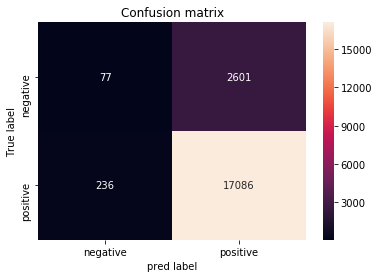

In [90]:
#plot the confusion matrix to describe the performance
import seaborn as sns
class_label=['negative','positive']
df_cm=pd.DataFrame(cm,index=class_label,columns=class_label)
sns.heatmap(df_cm,annot=True,fmt='d')
plt.title("Confusion matrix")
plt.xlabel("pred label")
plt.ylabel("True label")
plt.show()

* Conclusion-

In [91]:
#from prettytable import prettyTable

from prettytable import PrettyTable
Table1=PrettyTable()
Table1.field_names=['Type of vector','algo','f1_score','accuracy(percentage)','optimal_k']
Table1.add_row(['BOW',      'Brute force',.869,85.97,5])
Table1.add_row(['TFIDF',    'Brute force',.873,87.34,9])
Table1.add_row(['Avg-W2V',  'Brute force',.880,88.11,11])
Table1.add_row(['Tfidf-W2V','Brute force',.876,87.71,11])
print(Table1)


+----------------+-------------+----------+----------------------+-----------+
| Type of vector |     algo    | f1_score | accuracy(percentage) | optimal_k |
+----------------+-------------+----------+----------------------+-----------+
|      BOW       | Brute force |  0.869   |        85.97         |     5     |
|     TFIDF      | Brute force |  0.873   |        87.34         |     9     |
|    Avg-W2V     | Brute force |   0.88   |        88.11         |     11    |
|   Tfidf-W2V    | Brute force |  0.876   |        87.71         |     11    |
+----------------+-------------+----------+----------------------+-----------+


In [47]:
#from prettytable import prettyTable
from prettytable import PrettyTable
Table2=PrettyTable()
Table2.field_names=['Type of vector','algo','f1_score','accuracy(%)','optimal_k']
Table2.add_row(['BOW',      'Kd-tree',.857,85.66,11])
Table2.add_row(['TFIDF',    'Kd-tree',.862,85.47, 9])
Table2.add_row(['Avg-W2V',  'kd-tree',.853,85.3,11])
Table2.add_row(['Tfidf-W2V','Kd-tree',.858,85.97,11])
print(Table2)


+----------------+---------+----------+-------------+-----------+
| Type of vector |   algo  | f1_score | accuracy(%) | optimal_k |
+----------------+---------+----------+-------------+-----------+
|      BOW       | Kd-tree |  0.857   |    85.66    |     11    |
|     TFIDF      | Kd-tree |  0.862   |    85.47    |     9     |
|    Avg-W2V     | kd-tree |  0.853   |     85.3    |     11    |
|   Tfidf-W2V    | Kd-tree |  0.858   |    85.97    |     11    |
+----------------+---------+----------+-------------+-----------+


*F1 score combines precision and recall relative to a specific positive class -
The F1 score can be interpreted as a weighted  average of the precision and recall, where an F1 score reaches its best value  at 1 and worst at 0.



     * KNN model-

        * Split the dataset into two pieces: a training set and a testing set.
        
        * Train the model on the training set.
        
        * Test the model on the testing set, and evaluate how well we did.


     1.Pick a value for K.
        
     2.Search for the K observations in the training data that are "nearest" to the measurements of the unknown Amazone                                  
     data
     3.Use the most popular response value from the K nearest neighbors as the predicted response value for the unknown     
     amazone data.
        
        
        
        
    
        
        
        
    
[M]

M

M

complete